# Modular Virus Simulation

In [1]:
using Markdown
using InteractiveUtils
using Random, Distributions, StatsBase, Parameters, DataFrames, Plots
using CSV, Tables
using Pkg

#physical constants
const kt_boltzmann = 0.001987204118 * (273.15 + 37)
const ΔΔG = Normal(1.0, 1.7)

# module configuration
const module_sizes = Dict(
    :replication => 3,      # A, A*, B
    :assembly => 4,         # F, G, H, J  
    :host_interaction => 3  # D, E, K
)
const G = sum(values(module_sizes)) # number_of_genes
const module_names = [:replication, :assembly, :host_interaction]

#fixed parameters
const sim_length = 500 # number of generations 500
const F = -5.0 # initial_free_energy (of all proteins)

#variable parameters (some will be modified in the loop)
U = Poisson(5.0) # mutation_rate - 4.5
#L will be defined in the loop
N = 10000 # start_popsize
K = 10000 # carrying_capacity
R = 9 # fecundity - 4
const Rep = 1 #Replicate No.
const start_fitness = (1 / (1 + ℯ^(F/kt_boltzmann)))^G

0.9970073088166209

# Core Virus Struct

Here is a modular version, ready for epistasis:

In [2]:
mutable struct ModularVirus
    μ_counts::Dict{Symbol, Vector{Int64}}
    ΔG_values::Dict{Symbol, Vector{Float64}}
    fitness::Float64
    zombie::Bool
end

In [3]:
# Constructor for clean initialization
function ModularVirus()
    μ_counts = Dict(name => zeros(Int64, module_sizes[name]) for name in module_names)
    ΔG_values = Dict(name => zeros(Float64, module_sizes[name]) for name in module_names)
    return ModularVirus(μ_counts, ΔG_values, 1.0, false)
end

ModularVirus

# Core fitness function

New version:

In [4]:
function assembly_epistasis(assembly_ΔGs::Vector{Float64})
    # Stoichiometric balance - variance in stabilities hurts fitness
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in assembly_ΔGs]
    mean_stability = mean(stabilities)
    variance_penalty = exp(-var(stabilities) * 10.0)  # tune scaling factor
    return mean_stability * variance_penalty
end

function replication_epistasis(replication_ΔGs::Vector{Float64})
    # Rate-limiting - weakest link dominates
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in replication_ΔGs]
    return minimum(stabilities)
end

function host_module_independent(host_ΔGs::Vector{Float64})
    # Independent effects - simple product
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in host_ΔGs]
    return prod(stabilities)
end

function update_fitness!(virus::ModularVirus)
    assembly_contrib = assembly_epistasis(virus.ΔG_values[:assembly])
    replication_contrib = replication_epistasis(virus.ΔG_values[:replication])
    host_contrib = host_module_independent(virus.ΔG_values[:host_interaction])
    
    virus.fitness = assembly_contrib * replication_contrib * host_contrib
    virus.zombie = virus.fitness <= 0.0
end

update_fitness! (generic function with 1 method)

## Mutate Function

New version:

In [5]:
function mutate!(virus::ModularVirus, L, U, ΔΔG) 
    number_of_mutations = only(rand(U, 1))
    ΔΔG_values = rand(ΔΔG, number_of_mutations)
    
    # Choose modules proportionally to their size
    module_probs = [module_sizes[name] for name in module_names] ./ G
    
    for i in 1:number_of_mutations
        # Select module based on proportional targeting
        module_choice = rand(Categorical(module_probs))
        module_name = module_names[module_choice]
        
        # Select gene within module
        module_size = module_sizes[module_name]
        gene_index = rand(1:module_size)
        
        # Apply mutation - much cleaner with dictionaries!
        virus.μ_counts[module_name][gene_index] += 1
        virus.ΔG_values[module_name][gene_index] += ΔΔG_values[i]
        
        # Lethal mutation check
        if rand() < L
            virus.fitness = 0
            virus.zombie = true
            return virus.fitness
        end
    end
    
    # Update fitness if virus is still viable
    (virus.fitness > 0) && (update_fitness!(virus))
    (virus.fitness <= 0) && (virus.zombie = true)
    
    return virus.fitness
end

mutate! (generic function with 1 method)

# Other Key Functions

In [6]:
#creates new offspring virus by copying parent + its mutations
function reproduce(parent::ModularVirus, L, U, ΔΔG)
    sprog = deepcopy(parent)
    mutate!(sprog, L, U, ΔΔG)
    return sprog
end

#creates initial virus population
function initialize_population(N, F, start_fitness)
    initial_population = [ModularVirus() for _ in 1:N]
    
    # Set initial ΔG values for all genes in all modules
    for virus in initial_population
        for module_name in module_names
            fill!(virus.ΔG_values[module_name], F)
        end
        virus.fitness = start_fitness
    end
    
    return initial_population
end

#used to implement fitness-proportional selection
function get_weights(populace)
    weights = [v.fitness for v in populace]
    return Weights(weights / sum(weights))
end

#round a floating-point number to an integer
function probabilistic_round(number)
    frac = abs(number - floor(number))
    if rand() < frac # Simplified random number generation
        return ceil(Int, number)
    end
    return floor(Int, number)
end

probabilistic_round (generic function with 1 method)

# Report and Plotting Functions

In [7]:
#creates empty DataFrame with module-specific columns
function initialize_report()
    report = DataFrame(
        psiz = Int[], 
        q1fit = Float64[], 
        meanfit = Float64[],
        q2fit = Float64[], 
        maxfit = Float64[], 
        minfree = Float64[],
        meanfree = Float64[], 
        maxfree = Float64[], 
        minmut = Float64[],
        meanmut = Float64[], 
        maxmut = Float64[],
        # Module-specific mutation counts
        replication_meanmut = Float64[],
        assembly_meanmut = Float64[],
        host_meanmut = Float64[],
        # Module-specific free energies  
        replication_meanfree = Float64[],
        assembly_meanfree = Float64[],
        host_meanfree = Float64[]
    )
    return report
end

# Helper function to get all ΔG values from a ModularVirus
function get_all_ΔG(virus::ModularVirus)
    all_ΔG = Float64[]
    for module_name in module_names
        append!(all_ΔG, virus.ΔG_values[module_name])
    end
    return all_ΔG
end

# Helper function to get all mutation counts from a ModularVirus  
function get_all_mutations(virus::ModularVirus)
    return sum(sum(virus.μ_counts[module_name]) for module_name in module_names)
end

# Helper function to get module-specific statistics
function get_module_stats(populace, module_name::Symbol)
    mut_counts = [sum(v.μ_counts[module_name]) for v in populace]
    ΔG_values = [mean(v.ΔG_values[module_name]) for v in populace]
    return mean(mut_counts), mean(ΔG_values)
end

#updates DataFrame with both original and module-specific metrics
function report_update!(populace, report)
    # Original metrics
    fitness_values = [v.fitness for v in populace]
    all_ΔG_per_virus = [get_all_ΔG(v) for v in populace]
    all_mutations_per_virus = [get_all_mutations(v) for v in populace]
    
    # Module-specific metrics
    rep_mut, rep_free = get_module_stats(populace, :replication)
    asm_mut, asm_free = get_module_stats(populace, :assembly)
    host_mut, host_free = get_module_stats(populace, :host_interaction)
    
    push!(report, [
        length(populace), #psiz
        quantile(fitness_values, 0.25), #q1fit
        mean(fitness_values), #meanfit
        median(fitness_values), #q2fit
        maximum(fitness_values), #maxfit
        mean([minimum(ΔG_list) for ΔG_list in all_ΔG_per_virus]), #minfree
        mean([mean(ΔG_list) for ΔG_list in all_ΔG_per_virus]), #meanfree
        mean([maximum(ΔG_list) for ΔG_list in all_ΔG_per_virus]), #maxfree
        minimum(all_mutations_per_virus), #minmut
        mean(all_mutations_per_virus), #meanmut
        maximum(all_mutations_per_virus), #maxmut
        rep_mut, #replication_meanmut
        asm_mut, #assembly_meanmut
        host_mut, #host_meanmut
        rep_free, #replication_meanfree
        asm_free, #assembly_meanfree
        host_free #host_meanfree
    ])
end

#creates plots including module-specific panels
function plot_simulation(report)
    abscissa = 1:size(report, 1)
    
    p1 = plot(abscissa, report.psiz, 
        ylims = (0, maximum(report.psiz)),
        label = "pop size", linewidth = 3, title = "A) Population Size")
        
    p2 = plot(abscissa, [report.q1fit report.meanfit report.q2fit report.maxfit],
        label = ["Q1 fitness" "mean fitness" "median fitness" "max fitness"], 
        linewidth = 3, title = "B) Fitness Distribution")
        
    p3 = plot(abscissa, [report.minfree report.meanfree report.maxfree],
        label = ["min ΔG" "mean ΔG" "max ΔG"],
        linewidth = 3, title = "C) Free Energy Distribution")
        
    p4 = plot(abscissa, [report.minmut report.meanmut report.maxmut],
        label = ["min mutations" "mean mutations" "max mutations"],
        linewidth = 3, title = "D) Total Mutations")
        
    p5 = plot(abscissa, [report.replication_meanmut report.assembly_meanmut report.host_meanmut],
        label = ["replication" "assembly" "host interaction"],
        linewidth = 3, title = "E) Mutations by Module")
        
    p6 = plot(abscissa, [report.replication_meanfree report.assembly_meanfree report.host_meanfree],
        label = ["replication" "assembly" "host interaction"],
        linewidth = 3, title = "F) Mean ΔG by Module")
    
    plot(p1, p2, p3, p4, p5, p6, 
        titleloc = :left, 
        titlefont = font(12), 
        layout = (3, 2), 
        size = (1000, 1000))
end

plot_simulation (generic function with 1 method)

# Core Simulation Code

In [8]:
#simulates one generation of the population. fitness pushed to next generation
function synchronized_generation(populace, L, U, ΔΔG, R) 
    next_generation = ModularVirus[] # equivalent to Array{ModularVirus,1}() and eliminates type checking later
    
    for parent in populace
        offspring_count = probabilistic_round(R * parent.fitness)
        for r in 1:offspring_count
            child = reproduce(parent, L, U, ΔΔG)
            # Only add viable offspring (short-circuit evaluation)
            (child.fitness > 0) && push!(next_generation, child)
        end
    end
    
    return next_generation
end

#runs main sim and collects data into DataFrame
function synchronized_simulation(L, U, ΔΔG, R, N, K, F, start_fitness, sim_length; 
                                report_frequency = 20)
    # Initialize population and reporting
    population = initialize_population(N, F, start_fitness)
    report = initialize_report()
    
    generation = 0
    max_generations = sim_length
    
    while generation < max_generations
        generation += 1
        
        # Progress reporting
        if generation % report_frequency == 0
            println("Generation: $generation, Population size: $(length(population))")
        end
        
        # Collect data before selection/reproduction
        report_update!(population, report)
        
        # Generate next generation
        population = synchronized_generation(population, L, U, ΔΔG, R)
        population_size = length(population)
        
        # Apply carrying capacity constraint
        if population_size > K
            population = sample(population, K, replace = false)
        elseif population_size == 0
            println("Population extinct at generation $generation")
            break
        end
    end
    
    # Final report update if simulation completed
    if length(population) > 0
        report_update!(population, report)
    end
    
    return report, population
end

# Convenience function with default parameters
function run_simulation(; L = 0.01, R = 2.0, N = 1000, K = 10000, 
                        sim_length = 1000, report_frequency = 20)
    # These would need to be defined based on your parameter choices
    # U = Poisson distribution for mutations
    # ΔΔG = distribution for mutation effects  
    # F = initial free energy
    # start_fitness = calculated initial fitness
    
    return synchronized_simulation(L, U, ΔΔG, R, N, K, F, start_fitness, sim_length;
                                 report_frequency = report_frequency)
end

run_simulation (generic function with 1 method)

# Run the Simulation

Generation: 20, Population size: 11
Population extinct at generation 24


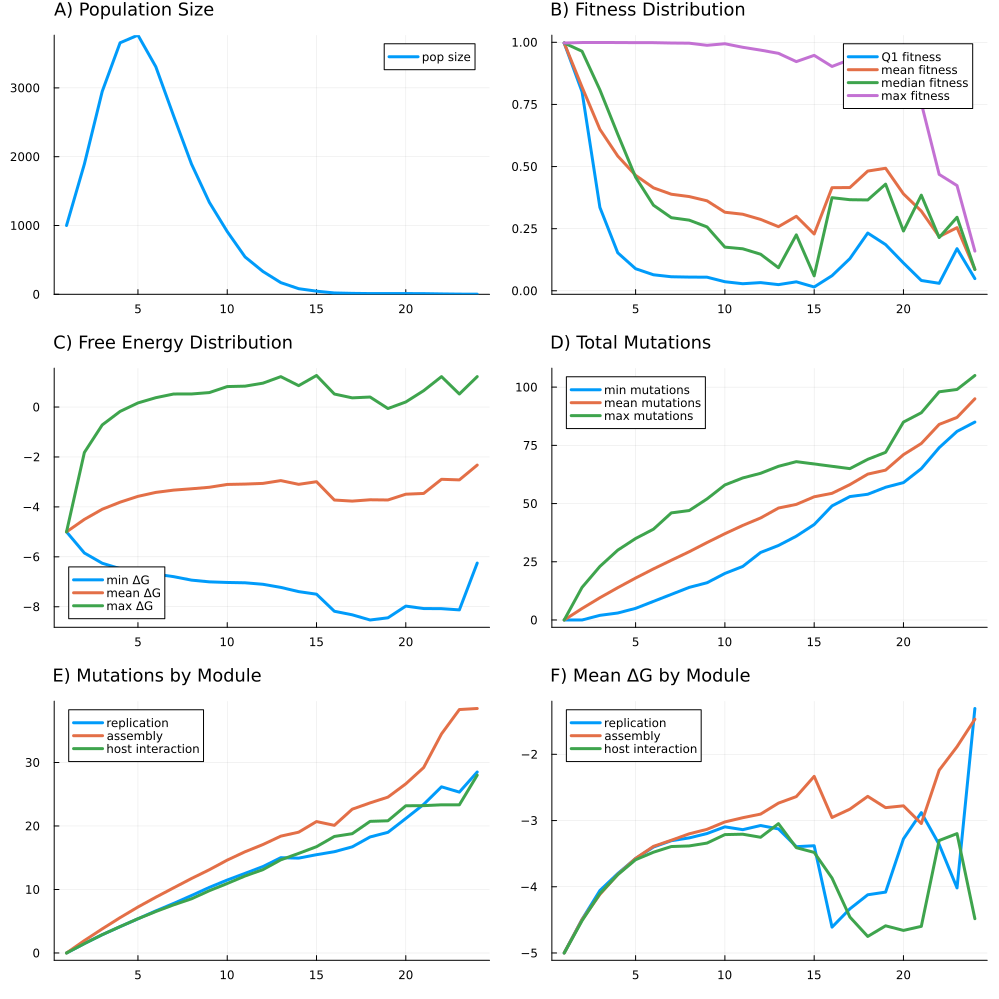

In [9]:
# Run the simulation
report, final_population = run_simulation()

# Plot the results
plot_simulation(report)

In [10]:
report

Row,psiz,q1fit,meanfit,q2fit,maxfit,minfree,meanfree,maxfree,minmut,meanmut,maxmut,replication_meanmut,assembly_meanmut,host_meanmut,replication_meanfree,assembly_meanfree,host_meanfree
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1000,0.997007,0.997007,0.997007,0.997007,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-5.0,-5.0
2,1893,0.801152,0.819853,0.963932,0.999017,-5.84768,-4.50038,-1.81931,0.0,4.92816,14.0,1.49076,1.95827,1.47913,-4.49348,-4.49647,-4.51249
3,2949,0.335567,0.649782,0.808443,0.999166,-6.25752,-4.09412,-0.716288,2.0,9.56392,23.0,2.87996,3.79688,2.88708,-4.05688,-4.11549,-4.10286
4,3655,0.152929,0.542205,0.629823,0.998943,-6.47649,-3.8112,-0.175745,3.0,13.8791,30.0,4.15212,5.56908,4.15787,-3.80055,-3.81433,-3.81768
5,3766,0.088809,0.464539,0.45715,0.998535,-6.60779,-3.57795,0.164557,5.0,18.0226,35.0,5.38768,7.23978,5.39511,-3.5737,-3.57093,-3.59157
6,3307,0.0644607,0.414265,0.344336,0.998454,-6.69426,-3.41952,0.374567,8.0,21.9441,39.0,6.62867,8.7853,6.53009,-3.4002,-3.38998,-3.47822
7,2591,0.0564988,0.388565,0.294183,0.997029,-6.79509,-3.32809,0.522347,11.0,25.6546,46.0,7.80857,10.2636,7.5824,-3.30441,-3.29743,-3.39265
8,1892,0.0551507,0.37922,0.284334,0.996368,-6.93431,-3.27392,0.523447,14.0,29.3145,47.0,9.04915,11.7326,8.53277,-3.26223,-3.20058,-3.3834
9,1336,0.0547642,0.362084,0.257037,0.98781,-7.00337,-3.21394,0.579605,16.0,33.2627,52.0,10.3331,13.1153,9.81437,-3.1962,-3.13254,-3.3402


Generation: 20, Population size: 10000
Generation: 40, Population size: 10000
Generation: 60, Population size: 10000
Generation: 80, Population size: 10000
Generation: 100, Population size: 10000
Generation: 120, Population size: 10000
Generation: 140, Population size: 10000
Generation: 160, Population size: 10000
Generation: 180, Population size: 10000
Generation: 200, Population size: 10000
Generation: 220, Population size: 10000
Generation: 240, Population size: 10000
Generation: 260, Population size: 10000
Generation: 280, Population size: 10000
Generation: 300, Population size: 10000
Generation: 320, Population size: 10000
Generation: 340, Population size: 10000
Generation: 360, Population size: 10000
Generation: 380, Population size: 10000
Generation: 400, Population size: 10000
Generation: 420, Population size: 10000
Generation: 440, Population size: 10000
Generation: 460, Population size: 10000
Generation: 480, Population size: 10000
Generation: 500, Population size: 10000


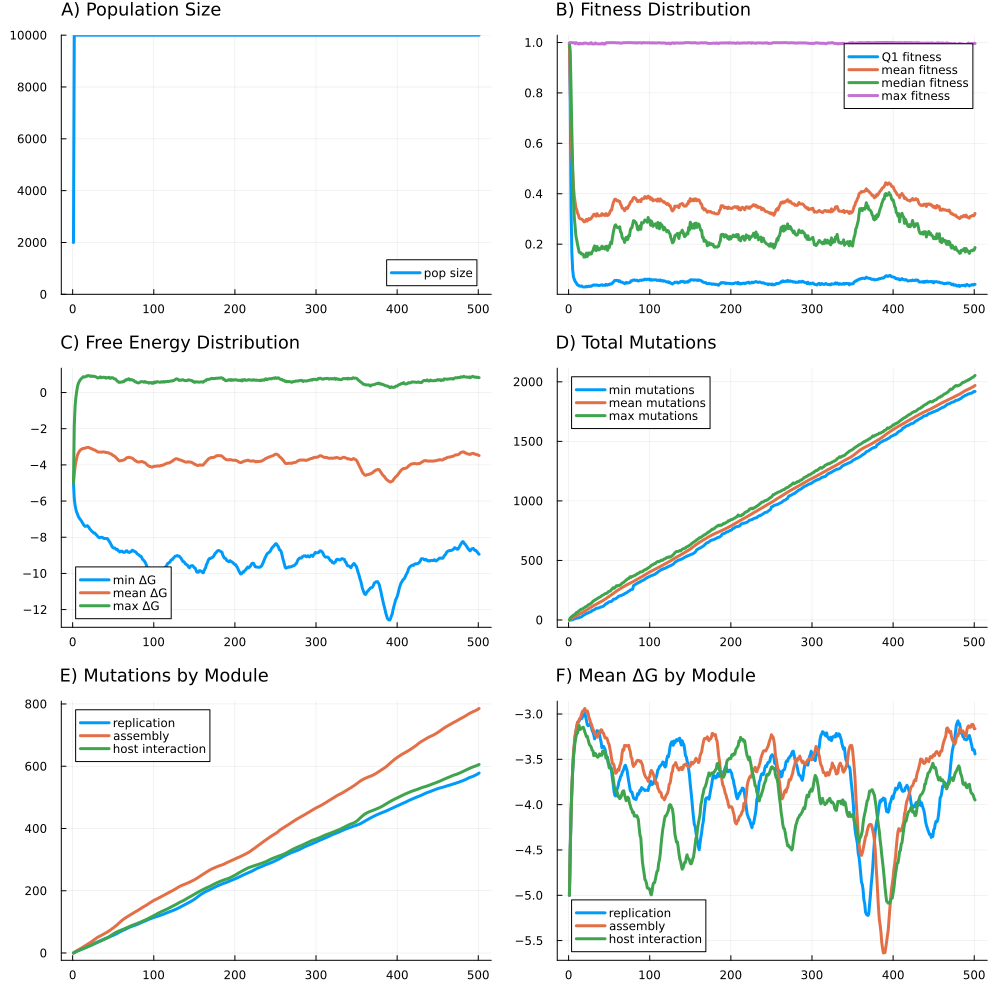

In [11]:
# Example with custom parameters
report, final_population = run_simulation(L = 0.02, R = 10, sim_length = 500, N = 2000)
plot_simulation(report)

# Parameter Sweeps

In [12]:
using Random, CSV, DataFrames

function run_simulation(; L = 0.01, U = nothing, ΔΔG = nothing, R = 2.0, 
                       N = 1000, K = 10000, F = -1.0, sim_length = 1000,
                       seed = nothing, output_dir = nothing, 
                       save_files = false, report_frequency = 20)
    
    # Set random seed for reproducibility
    if seed !== nothing
        Random.seed!(seed)
    else
        seed = rand(Int)
        Random.seed!(seed)
    end
    
    # Calculate derived parameters
    start_fitness = (1 / (1 + ℯ^(F/kt_boltzmann)))^G
    
    # Run simulation
    println("Starting simulation with seed $seed...")
    report, final_population = synchronized_simulation(
        L, U, ΔΔG, R, N, K, F, start_fitness, sim_length;
        report_frequency = report_frequency
    )
    
    # Add parameter columns to report for tracking
    report[!, :L] .= L
    report[!, :N] .= N  
    report[!, :R] .= R
    report[!, :K] .= K
    report[!, :F] .= F
    report[!, :seed] .= seed
    report[!, :sim_length] .= sim_length
    
    # Add distribution parameters if provided
    if U !== nothing && hasmethod(mean, (typeof(U),))
        report[!, :U_mean] .= mean(U)
    end
    if ΔΔG !== nothing && hasmethod(mean, (typeof(ΔΔG),))
        report[!, :ΔΔG_mean] .= mean(ΔΔG)
    end
    
    # File saving logic
    if save_files && output_dir !== nothing
        mkpath(output_dir)
        
        # Generate descriptive filenames
        U_str = U !== nothing ? "U$(Int(round(mean(U))))" : "Udef"
        base_name = "L$(L)_N$(N)_R$(R)_$(U_str)_seed$(seed)"
        
        csv_filename = joinpath(output_dir, "$(base_name).csv")
        png_filename = joinpath(output_dir, "$(base_name).png")
        
        # Save CSV
        CSV.write(csv_filename, report)
        println("Report saved to: $csv_filename")
        
        # Save plot
        p = plot_simulation(report)
        savefig(p, png_filename)
        println("Plot saved to: $png_filename")
        
        return report, final_population, csv_filename, png_filename
    else
        return report, final_population
    end
end

# Batch simulation function for parameter sweeps
function run_parameter_sweep(param_ranges::Dict; base_dir = "simulation_results", 
                           num_runs = 5, save_master_csv = true)
    
    mkpath(base_dir)
    master_results = DataFrame()
    
    # Get all parameter combinations
    param_names = collect(keys(param_ranges))
    param_values = collect(values(param_ranges))
    
    for param_combo in Iterators.product(param_values...)
        params = Dict(zip(param_names, param_combo))
        
        println("Running parameter combination: $params")
        
        # Create directory for this parameter set
        param_str = join(["$k$(v)" for (k,v) in params], "_")
        param_dir = joinpath(base_dir, param_str)
        mkpath(param_dir)
        
        for run in 1:num_runs
            println("  Run $run/$num_runs")
            
            run_dir = joinpath(param_dir, "run_$run")
            
            # Run simulation with current parameters
            result = run_simulation(;
                params...,
                seed = rand(Int),
                output_dir = run_dir,
                save_files = true
            )
            
            # Collect results for master CSV
            if save_master_csv && length(result) >= 1
                report = result[1]
                append!(master_results, report)
            end
        end
    end
    
    # Save master CSV
    if save_master_csv && !isempty(master_results)
        master_csv = joinpath(base_dir, "master_results.csv")
        CSV.write(master_csv, master_results)
        println("Master results saved to: $master_csv")
    end
    
    return master_results
end

# Example usage:
# Single run with file saving
# report, pop = run_simulation(L = 0.05, seed = 12345, 
#                             output_dir = "results/test_run", save_files = true)

# Parameter sweep
# results = run_parameter_sweep(
#     Dict(:L => 0.0:0.1:1.0, :N => [1000, 5000], :R => [1.5, 2.0, 2.5]);
#     base_dir = "parameter_sweep", num_runs = 3
# )

run_parameter_sweep (generic function with 1 method)

In [ ]:
#simulation run with the paramaters at the top 
function run_sim(seed::Int, output_dir::String, L::Float64, N::Int, U_poisson::Poisson, R::Int, K::Int) # L, N, U, R, K are now arguments
    Random.seed!(seed)

    variable1 = "L$(L)"
    variable2 = "N$(N)"
    variable3 = "U$(Int(mean(U_poisson)))" # Extract mean from Poisson
    variable4 = "K$(K)"
    variable5 = "R$(R)"
    seed_str = "$seed"

    csv_filename = joinpath(output_dir, "$(variable1)_$(variable2)_$seed_str.csv")
    png_filename = joinpath(output_dir, "$(variable1)_$(variable2)_$seed_str.png")

    synchronized_report = synchronized_simulation(L) # Pass L here

    #Add new columns for L, N, seed, U, R, K
    synchronized_report[!, :L] .= L
    synchronized_report[!, :N] .= N
    synchronized_report[!, :seed] .= seed
    synchronized_report[!, :U] .= Int(mean(U_poisson)) # Store the mean of Poisson U
    synchronized_report[!, :R] .= R
    synchronized_report[!, :K] .= K

    CSV.write(csv_filename, synchronized_report)
    plot_simulation(synchronized_report) # Plot after adding columns to report if they affect plot
    png(png_filename)

    #Combine to master CSV document based on N
    master_csv_dir = joinpath(base_dir, "master_csvs")
    mkpath(master_csv_dir)
    master_csv_filename = joinpath(master_csv_dir, "master_N$(N).csv")

    #Check if master CSV exists to determine if headers are needed
    if !isfile(master_csv_filename) || filesize(master_csv_filename) == 0
        CSV.write(master_csv_filename, synchronized_report, header=true)
    else
        CSV.write(master_csv_filename, synchronized_report, append=true, header=false)
    end

    return csv_filename, png_filename
end

base_dir = "C:\\Users\\jade-\\Desktop\\Simulation\\N=K=10000"
mkpath(base_dir)

mut_dir = joinpath(base_dir, "U$(Int(mean(U)))") # Use Int(mean(U)) for directory name
group_dir = joinpath(mut_dir, "R$(R)_N$(N)_K$(K)") # L is removed from here

num_runs = 5

#Main loop over L values
for L in 0.0:0.1:1.0
    println("Running simulations for L = $L")
    L_dir = joinpath(group_dir, "L$(L)") # Create a directory for each L
    mkpath(L_dir)

    for i in 1:num_runs
        seed = rand(Int)
        println("  Run $i, seed = $seed")
        run_dir = joinpath(L_dir, "run_$i")
        mkpath(run_dir)
        # Pass all relevant parameters to run_sim
        run_sim(seed, run_dir, L, N, U, R, K)
    end
    println("Simulations for L = $L complete.\n")
end

println("All simulation runs complete.")